<bold><font size="6">Transfer Learning Tremor Location (TL): Tutorial</font></bold>
# Introduction

In this jupyter notebook we show how to use the `tl` package. Let's first import this package and other dependencies used in this tutorial:

In [1]:
# Python Standard Library
import warnings

# Other dependencies
import numpy as np
import pandas as pd
import tl

from obspy.clients.fdsn.client import Client
from obspy.clients.fdsn.mass_downloader import (
    CircularDomain, Restrictions, MassDownloader
)
from obspy import UTCDateTime


warnings.filterwarnings('ignore')

Our study case is the tremor from the Kilauea summit caldera collapse in 2018. For the sake of technical illustration, we use a minimal working example. The results are not satisfying since the training and prediction data sets are very small. Nonetheless, this example can be modified to run with the full dataset and reproduce the results presented in [van der Laat *et al*. (in prep.)]().

## Command-line programs

For every main step in this analysis we use command-line programs included in the `tl` package. 

Almost every program requires the path to a configuration file in the `YAML` format as argument.

If you were in your console and the installation of this package was succesful, you would be able to run the programs using a command like the following:

    $ tl-[PROGRAM] config.yml

where `[PROGRAM]` can be any of the following:

1. `get-wfs-eq`
1. `feature-extraction`
1. `feature-engineering`
1. `train`
1. `predict`


Since we are in a jupyter notebook we will be appending a `!` in front or using this type of command:

    %run ../bin/tl-[PROGRAM] config.yml

## `YAML` configuration file

This file contains all the user-defined parameters that you can modify. We will use the `config.yml` file in this folder. Open this in a text editor while following this tutorial, we will be modifying it slightly.

For each program a different set of parameters in the configuration file is used. To know which parameters are being used in a particular program run this command line:

    $ tl-help [PROGRAM]
    
For example:

In [2]:
!tl-help train-EQ



============== Transfer Learning Tremor Location: Parameters Used ==============

 ============================== Program: train-EQ ===============================


-------------------------------------- io --------------------------------------
	 output_dir
	 overwrite
---------------------------------- amplitude -----------------------------------
	 channels_csv
	 bands
----------------------------------- engineer -----------------------------------
	 ratio_same_station
	 ratio_diff_bands
	 transformations
----------------------------------- dataset ------------------------------------
	 magnitude_min
	 magnitude_max
	 n_events
------------------------------------ train -------------------------------------
	 test_size
	 random_state
	 feat_folder




The options for `tl-help` can be printed by using this command:

In [3]:
!tl-help -h

usage: tl-help [-h]
               {get-wfs-eq,feature-extraction-SY,feature-extraction-EQ,feature-extraction-TR,feature-engineer,train-SY,train-EQ,predict}

positional arguments:
  {get-wfs-eq,feature-extraction-SY,feature-extraction-EQ,feature-extraction-TR,feature-engineer,train-SY,train-EQ,predict}
                        name of the program

options:
  -h, --help            show this help message and exit


For the sake of clarity and brevity we won't be discussing each of the parameters, 
but you are welcome to run `tl-help` at anytime in a new cell so you can have in mind which parameters are needed in any step.

## Outputs

Each of the `tl` programs will create a folder for output with a name related to the type of output (e.g. `AMP` for amplitudes) and sometimes a suffix for the type of data (e.g. `TR` for tremor). 

Keep a file explorer open during this tutorial so you can see the changes in the directory.

If you are running a same program different configurations, you can choose to overwrite the folder or to create a new one (`io.overwrite` parameter in the configuration file). 

Each time a program runs, a `JSON` version of the configuration file is written so you can keep track of your experiments settings. 

# Set-up the experiment

## Cartesian projection

The `tl` package works with cartesian coordinates. [Find out your EPSG code](https://epsg.io/). For this example, we use the [NAD83 / Hawaii zone 1](https://epsg.io/26961) projection with the code `26961`. In the configuration file

```yaml
projection:
    epsg: 26961
```

Let's have a variable with this short code to be used in this notebook:

In [4]:
epsg = 26961

## Seismic stations

We use two files containing seismic stations information: 1) a `STATIONXML` inventory will be used for removing response information; and 2) a `CSV` file will be used for controlling the network configuration. 

### `STATIONXML` response file

Let's first obtain our inventory from the IRIS-DMC for the area and time range that we desire and write it to a file for later use:

In [5]:
client = Client('IRIS')

inventory = client.get_stations(
    starttime=UTCDateTime(2018, 1, 1),
    endtime=UTCDateTime(2019, 1, 1),
    network='HV',
    channel='EH*,HH*',
    minlatitude=19.3270,
    maxlatitude=19.4704,
    minlongitude=-155.3339,
    maxlongitude=-155.1631,
    level='channel'
)

inventory.write('inventory.xml', format='STATIONXML')

Annotate the path to this file in your configuration file:

```yaml
preprocess:
    inventory: inventory.xml
```

### Stations `CSV` file
For user easy network configuration we convert the `STATIONXML` file to a simple dataframe:

In [6]:
cha = tl.inventory.to_dataframe(inventory)

In this case we won't some stations, we can filter them out:

In [7]:
cha = cha[~cha.station.isin(['NAHU', 'NPT', 'HAT', 'KKO', 'OBL'])]

We also perform the transformation of the coordinate system:

In [8]:
cha['x'], cha['y'] = tl.projection.geographic_to_cartesian(
    cha.longitude.values, cha.latitude.values, epsg
)
cha.reset_index(inplace=True)
cha

,index,network,station,channel,longitude,latitude,z,x,y
0,0,HV,AHUD,EHE,-155.263462,19.371567,1051.0,524848.012953,59592.976092
1,1,HV,AHUD,EHN,-155.263462,19.371567,1051.0,524848.012953,59592.976092
2,2,HV,AHUD,EHZ,-155.263462,19.371567,1051.0,524848.012953,59592.976092
3,3,HV,BYL,HHE,-155.259872,19.412086,1079.0,525218.906428,64078.741166
4,4,HV,BYL,HHN,-155.259872,19.412086,1079.0,525218.906428,64078.741166
5,5,HV,BYL,HHZ,-155.259872,19.412086,1079.0,525218.906428,64078.741166
6,6,HV,CPKD,EHZ,-155.324317,19.391443,1038.0,518452.706814,61785.625287
7,7,HV,DEVL,HHE,-155.240608,19.373568,1046.0,527248.588901,59817.880035
8,8,HV,DEVL,HHN,-155.240608,19.373568,1046.0,527248.588901,59817.880035
9,9,HV,DEVL,HHZ,-155.240608,19.373568,1046.0,527248.588901,59817.880035


Let's write the dataframe to a `csv` file:

In [9]:
cha.to_csv('channels.csv', index=False)

Annotate the path to this file in your configuration file:

```yaml
features:
    channels_csv: channels.csv
```

## Earthquake catalog

This package uses a catalog formatted as a `csv` file as following:

| time | latitude | longitude | depth | magnitude | eventid | x | y | z |
| ---- | -------- | --------- | ----- | --------- | ------- | - | - | - |
| 2018-04-29 01:24:11 | 19.40776 | -155.29421 | 1.265 | 0.64 | 42905052 | 521613 | 63595 | -1265 |

Let's get a catalog from IRIS:

In [10]:
catalog = client.get_events(
    starttime=UTCDateTime(2018, 7, 1),
    endtime=UTCDateTime(2018, 7, 2),
    minlatitude=19.3270,
    maxlatitude=19.4704,
    minlongitude=-155.3339,
    maxlongitude=-155.1631,
    maxdepth=5,
    minmagnitude=2,
    maxmagnitude=4,
)

Now we will convert the ObsPy catalog to a pandas dataframe, transform the coordinates and finally export it as a `csv` file:

In [11]:
# Create pandas dataframe
data = dict(eventid=[], time=[], latitude=[], longitude=[], depth=[], magnitude=[])
for event in catalog:
    data['eventid'].append(str(event.origins[0].resource_id).split('=')[-1])
    data['time'].append(event.origins[0].time)
    data['latitude'].append(event.origins[0].latitude)
    data['longitude'].append(event.origins[0].longitude)
    data['depth'].append(event.origins[0].depth)
    data['magnitude'].append(event.magnitudes[0].mag)
df = pd.DataFrame(data)

# Coordinates transformation
df['x'], df['y'] = tl.projection.geographic_to_cartesian(
    df.longitude.values, df.latitude.values, epsg
)
df['z'] = -df.depth

# Export CSV
df.to_csv('catalog.csv', index=True)
df

,eventid,time,latitude,longitude,depth,magnitude,x,y,z
0,32403086,2018-07-01T23:58:42.080000Z,19.402500,-155.262497,160.0,3.10,524944.671330,63017.239827,-160.0
1,32403036,2018-07-01T23:57:51.810000Z,19.398834,-155.275665,1120.0,2.72,523562.108265,62609.604080,-1120.0
2,32402936,2018-07-01T23:55:26.580000Z,19.416000,-155.271164,980.0,2.73,524032.352554,64510.408815,-980.0
3,32402986,2018-07-01T23:54:06.820000Z,19.421167,-155.272339,400.0,2.70,523908.190770,65082.209617,-400.0
4,32402886,2018-07-01T23:49:16.960000Z,19.399666,-155.268173,390.0,3.10,524348.918817,62702.729158,-390.0
...,...,...,...,...,...,...,...,...,...
426,32367836,2018-07-01T00:07:52.620000Z,19.399166,-155.270493,360.0,2.80,524105.308769,62647.060015,-360.0
427,32367886,2018-07-01T00:05:37.600000Z,19.400333,-155.293167,1250.0,2.58,521723.558963,62773.269981,-1250.0
428,32367786,2018-07-01T00:04:39.380000Z,19.421833,-155.281174,-790.0,2.54,522980.225595,65154.745661,790.0
429,32367686,2018-07-01T00:01:45.700000Z,19.412500,-155.277832,1200.0,2.46,523332.542122,64122.071327,-1200.0


Annotate the path to this file in your configuration file:

```yaml
dataset:
    catalog: catalog.csv
    magnitude_min: 1
    magnitude_max: 5
    n_events: 100
```
In this section of the configuration file you can control how the filter the catalog.

# Synthetic tests

We run a synthetic test in order to have an idea of how well this dataset in combination with the network configuration can do for our purposes.

## Synthetic amplitudes 

In this case we don't extract features from seismic data, but we synthetize them based on the amplitude decay model. Use the `SY` argument in this step:

2022-09-06 16:36:56,437 - INFO - Calculating amplitudes...
2022-09-06 16:36:56,954 - INFO - Writing output...
2022-09-06 16:36:57,442 - INFO - Feature extraction done.


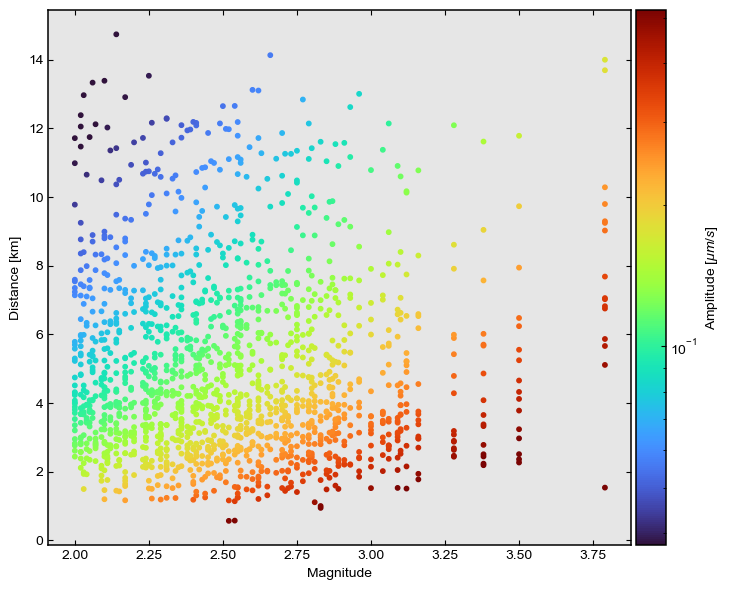

In [12]:
%run ../bin/tl-feature-extraction config.yml SY

This program created a folder with name `AMP` which contains the synthetic amplitude data, metadata and the figure above. 

## Feature engineering

Instead of using the seismic amplitudes at each station, we use different transformations of the ratios of the amplitudes between each pair of stations.

In [13]:
%run ../bin/tl-feature-engineering config.yml

2022-09-06 16:36:57,609 - INFO - Feature engineering...


2022-09-06 16:37:00,842	INFO worker.py:1518 -- Started a local Ray instance.


2022-09-06 16:37:07,760 - INFO - 480 features.


## Training

Now we can train the model based on synthetic features:

2022-09-06 16:37:09,725 - INFO - 480 features
2022-09-06 16:37:09,726 - INFO - Loading data...
2022-09-06 16:37:09,754 - INFO - Training with 70.0% of the dataset
2022-09-06 16:37:09,755 - INFO - n=100, n(train)=70, n(test)=30
2022-09-06 16:37:09,758 - INFO - Training...
2022-09-06 16:37:09,763 - INFO - Best alpha: 0.1
2022-09-06 16:37:09,763 - INFO - Predicting test set...
2022-09-06 16:37:09,765 - INFO - Test error: 410 m
2022-09-06 16:37:09,765 - INFO - Standard deviation (xyz): [ 330 1201 1480] m
2022-09-06 16:37:09,766 - INFO - Prediction interval (xyz): [ 647 2354 2900] m
2022-09-06 16:37:10,648 - INFO - Training with the whole data set...
2022-09-06 16:37:10,650 - INFO - Training...
2022-09-06 16:37:10,653 - INFO - Predicting...
2022-09-06 16:37:10,654 - INFO - Total error: 33 m
2022-09-06 16:37:10,655 - INFO - Standard deviation (xyz): [ 6 10 50] m
2022-09-06 16:37:10,655 - INFO - Prediction interval (xyz): [13 20 98] m


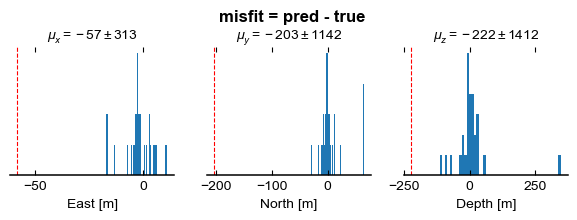

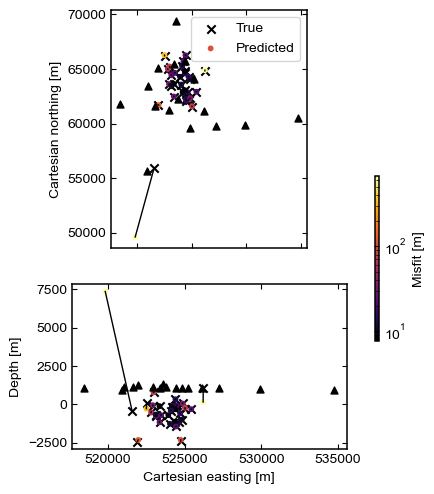

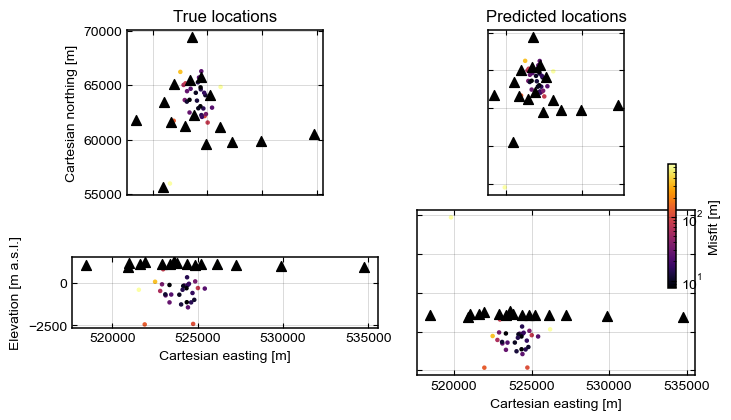

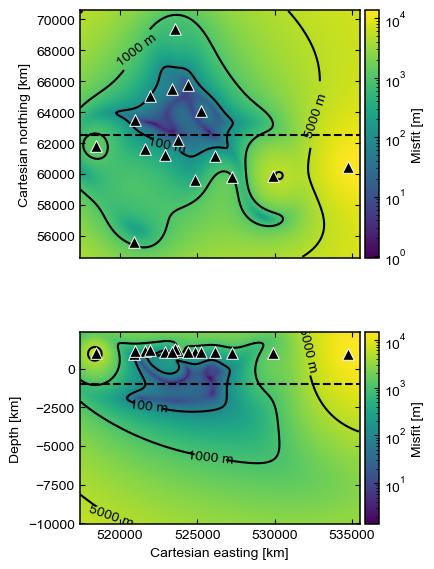

In [14]:
%run ../bin/tl-train config.yml SY

# Learning from earthquakes: dataset and model training
## Download earthquake waveforms

We download one file per event in parallel, so in the configuration file you can limit the number of threads (4 is recommended, higher numbers of threads results in poor returns from the FDSN client).

```yaml
performance:
    max_workers: 4
```

Run the program, this might take a while:

In [15]:
!tl-get-wfs-eq config.yml

2022-09-06 16:37:26,235 - INFO - Downloading...
2022-09-06 16:37:26,238 - INFO - Done


You can scan the data you just download to count the number of events and stations/channel per event. The output can be used to clean the data afterwards.

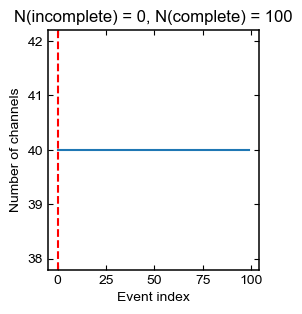

In [16]:
%run ../bin/tl-scan -i WFS_EQ/ -o .

This program outputs a folder `WFS_SCAN` and the plot above which shows the number of channels per event. 

There's three alternatives for dealing with incomplete data:
1. Moving the incomplete files to out of the folder (easy way, works fine if the incomplete files are just a few).
2. Keep the files; but drop the incomplete events when training (this is equivalent to 1., but gives you the possibility to consider option 3).
3. Keep the files; perform missing values imputation (this advanced option should be used if the missing values are too many).

For this example we will go with option 1. consider 40 channels, no more no less. We will clean the data using this cuttoff, by moving the incomplete files to another folder:

In [17]:
%run ../bin/tl-clean -i WFS_EQ -o . -f WFS_SCAN/count_channels_per_event.csv -n 40

2022-09-06 16:37:27,299 - INFO - 0 incomplete files were moved out of the folder.
2022-09-06 16:37:27,300 - INFO - 100 files remain in the folder.


## Measuring amplitudes

To measure the amplitudes from the data we will be using the `tl-feature-extraction` program with the `EQ` argument.

2022-09-06 16:37:27,326 - INFO - Measuring amplitudes...
2022-09-06 16:37:47,806 - INFO - Writing output...
2022-09-06 16:37:48,168 - INFO - Feature extraction done.


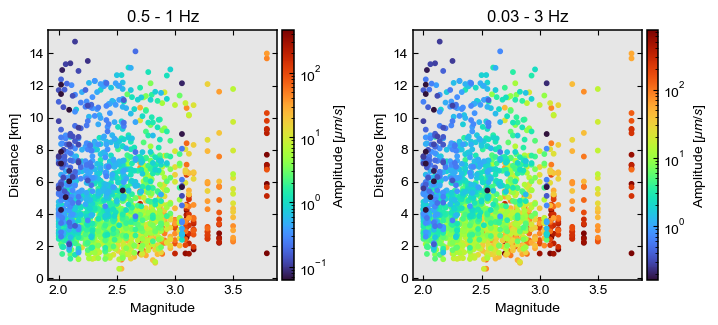

In [18]:
%run ../bin/tl-feature-extraction config.yml EQ

Again, this program created a folder with name `AMP` which contains the amplitude data and metadata and the figure above. Notice that the synthetic data from before was overwritten. 

Notice the expected amplitude/distance/magnitude distribution, compare to the plot corresponding to the synthetic data.

## Feature engineering

Now that we have the amplitudes we can engineer the features.

In [19]:
!tl-feature-engineering config.yml

2022-09-06 16:37:50,683 - INFO - Feature engineering...
2022-09-06 16:37:53,959	INFO worker.py:1518 -- Started a local Ray instance.
2022-09-06 16:38:01,382 - INFO - 12640 features.


The output of this program is the folder `FEAT` which contains the features data and metadata. 

## Training

Use the `train` program with `EQ` argument:

2022-09-06 16:38:06,587 - INFO - 12640 features
2022-09-06 16:38:06,588 - INFO - Loading data...
2022-09-06 16:38:07,196 - INFO - Training with 70.0% of the dataset
2022-09-06 16:38:07,207 - INFO - n=99, n(train)=69, n(test)=30
2022-09-06 16:38:07,219 - INFO - Training...
2022-09-06 16:38:07,228 - INFO - Best alpha: 10000.0
2022-09-06 16:38:07,229 - INFO - Predicting test set...
2022-09-06 16:38:07,230 - INFO - Test error: 1597 m
2022-09-06 16:38:07,231 - INFO - Standard deviation (xyz): [1205 1273  995] m
2022-09-06 16:38:07,232 - INFO - Prediction interval (xyz): [2361 2495 1951] m
2022-09-06 16:38:08,195 - INFO - Training with the whole data set...
2022-09-06 16:38:08,206 - INFO - Training...
2022-09-06 16:38:08,214 - INFO - Predicting...
2022-09-06 16:38:08,217 - INFO - Total error: 1004 m
2022-09-06 16:38:08,218 - INFO - Standard deviation (xyz): [737 735 568] m
2022-09-06 16:38:08,218 - INFO - Prediction interval (xyz): [1444 1442 1113] m


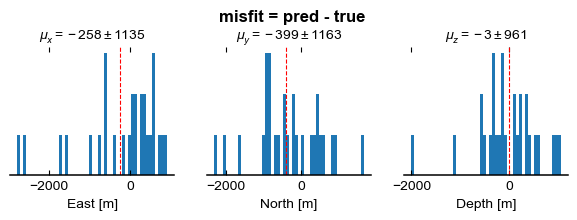

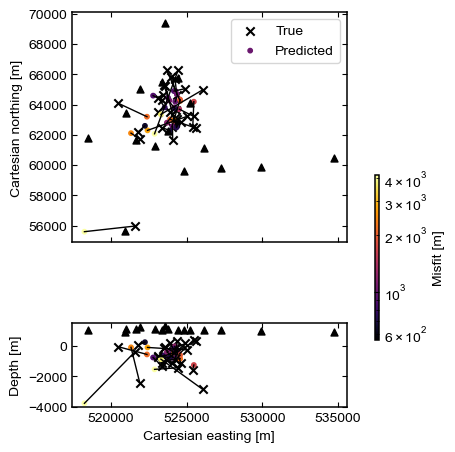

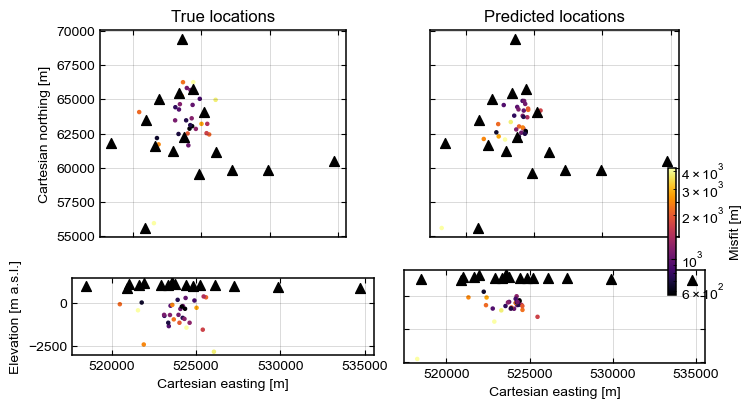

In [20]:
%run ../bin/tl-train config.yml EQ

The output of this program is the `MODEL_EQ` folder which contains pickle files for the model and scalers, the figures above and the true and predicted data for the test data set. 

# Transfering learning to tremor: predicting tremor source location
## Download waveforms

Use the following code to donwload continuous data for the day May 12, 2018. This might take a while depending on your internet connection.

In [21]:
df = pd.read_csv('channels.csv')

mdl = MassDownloader(providers=['IRIS'])

mdl.download(
    CircularDomain(
        latitude  = 19.410563,
        longitude = -155.276249,
        minradius = None,
        maxradius = 0.14
    ),
    Restrictions(
        starttime = UTCDateTime(2018, 5, 12),
        endtime   = UTCDateTime(2018, 5, 13),
        network   = 'HV',
        station   = ','.join(df.station.unique()),
        location  = '*',
        channel   = 'HH*,EH*',
        chunklength_in_sec = 86400,
        reject_channels_with_gaps = False,
        minimum_length = 0.0,
    ),
    threads_per_client = 10,
    mseed_storage = 'WFS_TR',
    stationxml_storage = 'stations'
)

[2022-09-06 16:38:08,914] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2022-09-06 16:38:08,942] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2022-09-06 16:38:08,946] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2022-09-06 16:38:08,947] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2022-09-06 16:38:09,320] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.37 seconds)
[2022-09-06 16:38:09,323] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 16 stations (40 channels).
[2022-09-06 16:38:09,327] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 16 stations.
[2022-09-06 16:38:09,334] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 40 time intervals/channels before downloading: EXIS

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x1af026170>}

Scan the files downloaded and check the figure in the output folder:

In [22]:
!obspy-scan WFS_TR -o WFS_TR_SCAN.pdf

## Feature extraction

For extracting features in continuous we use the same program (`tl-feature_extraction`) with the `TR` argument.

2022-09-06 16:38:12,770 - INFO - Measuring amplitudes...
(PoolActor pid=87589) Loading files...
(PoolActor pid=87589) 2018-05-12T00:00:00.000000Z
(PoolActor pid=87589) Done
2022-09-06 16:38:38,785 - INFO - Writing output...
2022-09-06 16:38:39,114 - INFO - Feature extraction done.


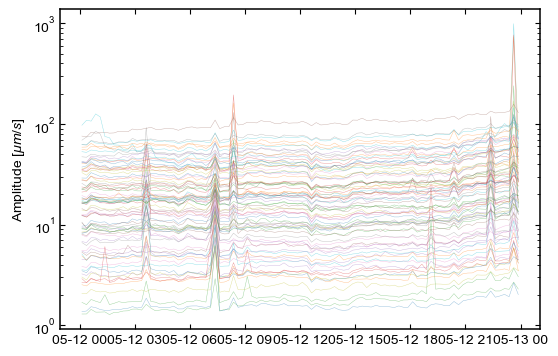

In [23]:
%run ../bin/tl-feature-extraction config.yml TR

The output of this program is under the `AMP` folder.

## Feature engineering

Run the feature engineering program:

In [24]:
!tl-feature-engineering config.yml

2022-09-06 16:38:41,378 - INFO - Feature engineering...
2022-09-06 16:38:45,552	INFO worker.py:1518 -- Started a local Ray instance.
2022-09-06 16:38:52,543 - INFO - 12640 features.


Again, this program outputs the `FEAT` folder.

## Location prediction

Finally, we can obtain the locations of the tremor:

2022-09-06 16:38:57,090 - INFO - 12640 features
2022-09-06 16:38:57,091 - INFO - Loading data...


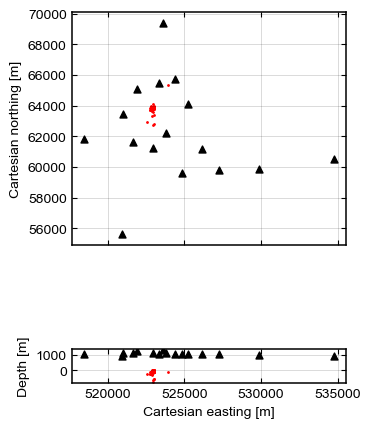

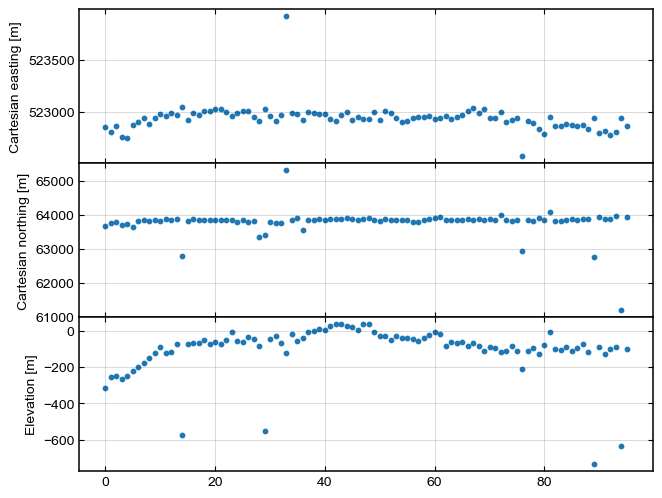

In [25]:
%run ../bin/tl-predict config.yml